### Практический проект курса  https://stepik.org/course/4852 

In [46]:
import pandas as pd
import numpy as np

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Описание данных:

<br><b>events_train.csv </b> - данные о действиях, которые совершают студенты со стэпами

step_id - id стэпа
<br>user_id - анонимизированный id юзера
<br>timestamp - время наступления события в формате unix date
<br>action - событие, возможные значения: 
<br>discovered - пользователь перешел на стэп
<br>viewed - просмотр шага,
<br>started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
<br>passed - удачное решение практического шага



<b>submissions_train.csv</b> - данные о времени и статусах сабмитов к практическим заданиям

step_id - id стэпа
<br>timestamp - время отправки решения в формате unix date
<br>submission_status - статус решения
<br>user_id - анонимизированный id юзера

In [48]:
event_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
event_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [49]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [50]:
# рейтинг пользователей по количеству отправленных решений
submissions_data.loc[submissions_data['submission_status'] == 'correct'].groupby('user_id').aggregate({'submission_status': 'count'}).sort_values(by='submission_status', ascending=False)

,submission_status
user_id,
1046,421
5552,186
17135,168
6183,142
8461,135
...,...
6191,1
6184,1
6166,1


In [51]:
event_data['date'] = pd.to_datetime(event_data['timestamp'], unit='s')

In [52]:
event_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [53]:
event_data['day'] = event_data['date'].dt.to_period('D')
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<Axes: xlabel='day'>

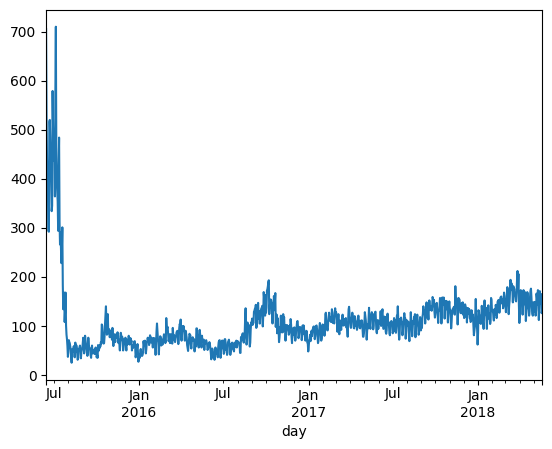

In [54]:
#количество уникальных пользователей на курсе по дням
event_data.groupby('day')['user_id'].nunique().plot()

In [55]:
#первые события на курсе
event_data.loc[event_data['timestamp'] == min(event_data['timestamp'])]

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15


In [56]:
min(event_data['timestamp'])

1434340848

In [57]:
submissions_data['date'] = pd.to_datetime(submissions_data['timestamp'], unit='s')
submissions_data['day'] = event_data['date'].dt.to_period('D')

In [58]:
users_scores = submissions_data.pivot_table(index='user_id',
                                            columns='submission_status',
                                            values= 'step_id',
                                            aggfunc= 'count',
                                            fill_value= 0
                                           ).rename_axis('index', axis="columns").reset_index()

users_scores.head()

index,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Что хотим посчитать?

1) Сколько уникальных степов прошел пользователь
2) Сколько правильных и сколько неправильных сабмитов решений
3) Сколько дней пользователь провел на курсе

Далее сравним эти результаты для пользователей которые закончили курс и которые бросили и выясним есть ли значимое раличие.

Кого считать бросившим курс?

In [63]:
# посчитаем промежутки между заходами на курс для пользователей

gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
            .groupby('user_id')['timestamp'].apply(list) \
            .apply(np.diff).values

<Axes: >

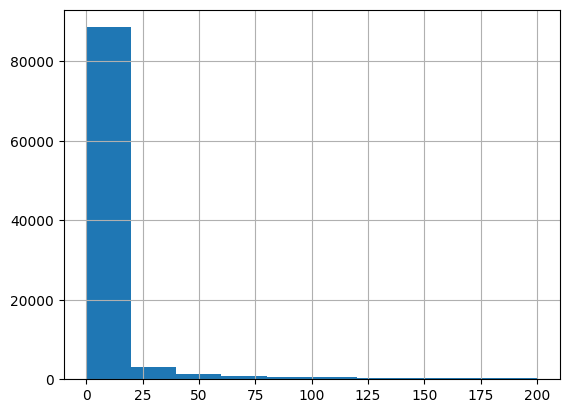

In [64]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 60 * 60) #перевод из секунд в дни
gap_data.hist()

<Axes: >

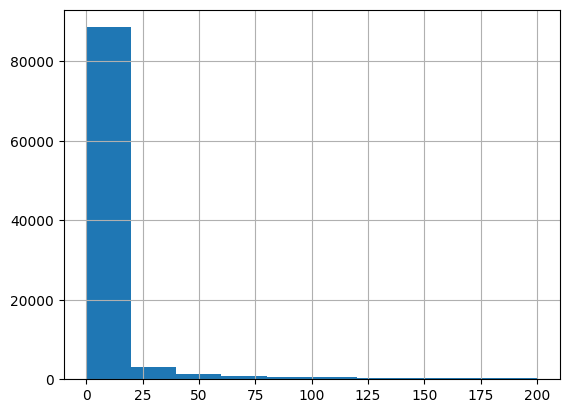

In [65]:
gap_data[gap_data < 200].hist()

In [70]:
# т.е. только 5% пользователей возвращается на курс после 60 дней перерыва (и более); 
# 10% возвращаются после перерыва 18 дней и более
gap_data.quantile(0.95) # 59.7 дней
gap_data.quantile(0.90) # 18.3 дней

18.325995370370403

In [18]:
#найти id автора курса, то есть пользователя который прорешал больше всего степов

new_df = submissions_data.pivot_table(index='user_id', columns='submission_status',values='step_id', aggfunc='count')

new_df[new_df['correct'] == new_df['correct'].max()]

submission_status,correct,wrong
user_id,,
1046,421.0,513.0


In [19]:
users_data = event_data.groupby('user_id', as_index=False)\
            .agg({"timestamp": "max"}).rename(columns={'timestamp': 'last_timestamp'})

In [20]:
#возьмем в качестве порогового значение 30 дней
drop_out_threshold = 30 * 24 * 60 * 60 #30 days in seconds

In [21]:
users_data['is_gone_user'] = (event_data['timestamp'].max() - users_data['last_timestamp']) > drop_out_threshold

In [22]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [23]:
user_events_data = event_data.pivot_table(index='user_id',
                                            columns='action',
                                            values= 'step_id',
                                            aggfunc= 'count',
                                            fill_value= 0
                                           ).reset_index()
user_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [24]:
users_data = users_data.merge(users_scores, how='outer', on='user_id')

In [25]:
users_data = users_data.fillna(0)

In [26]:
users_data = users_data.merge(user_events_data, how='outer', on='user_id')

In [27]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [28]:
#количество уникальных дней пользователя в приложении
users_day = event_data.groupby('user_id')['day'].nunique().to_frame().reset_index()

In [29]:
users_data = users_data.merge(users_day, how='outer')

In [30]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [31]:
users_data['passed_course'] = users_data['passed'] > 170

In [32]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [33]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [34]:
total_users = event_data['user_id'].nunique()
total_users

19234

In [35]:
100 * 1425 / total_users #процент прошедших курс "до конца" (прошедших 170 степов)

7.408755329104711

In [36]:
users_data['passed_course'].value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_course, dtype: float64

In [75]:
#проверка что при merge не потерялись пользователи
users_data.user_id.nunique()

19234

In [74]:
event_data.user_id.nunique()

19234